January 2019

# World Health Organization Mortality Analysis

## Introduction
This is the second part of an assignment for my Health Data Sciecne MSc.  I will be analysing data from the World Health Organization (avaliable <a href ='https://www.who.int/healthinfo/statistics/mortality_rawdata/en/'>here</a>.  I will be using Pandas and standard modules for my analysis.

In [20]:
#preliminaries
import pandas as pd
import re
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Load WHO dataframes diretly from the web
pop_df = pd.read_csv('https://www.who.int/healthinfo/Pop.zip?ua=1', compression='zip', index_col=False, \
                     na_values=["NaN"])
mort_df = pd.read_csv('https://www.who.int/healthinfo/statistics/Morticd10_part1.zip?ua=1',compression='zip',\
                      na_values=["NaN"],low_memory=False)
mort_df = mort_df.append(pd.read_csv('https://www.who.int/healthinfo/statistics/Morticd10_part2.zip?ua=1',compression='zip',\
                       na_values=["NaN"],low_memory=False))
country_codes_df = pd.read_csv('https://www.who.int/healthinfo/statistics/country_codes.zip?ua=1',compression='zip')

In [3]:
#Inspect data frames
pop_df.head()

,Country,Admin1,SubDiv,Year,Sex,Frmat,Pop1,Pop2,Pop3,Pop4,...,Pop18,Pop19,Pop20,Pop21,Pop22,Pop23,Pop24,Pop25,Pop26,Lb
0,1060,NaN,NaN,1980,1,7,137100.0,3400.0,15800.0,NaN,...,NaN,5300.0,NaN,2900.0,NaN,NaN,NaN,NaN,6500.0,5000.0
1,1060,NaN,NaN,1980,2,7,159000.0,4000.0,18400.0,NaN,...,NaN,6200.0,NaN,3400.0,NaN,NaN,NaN,NaN,7500.0,6000.0
2,1125,NaN,NaN,1955,1,2,5051500.0,150300.0,543400.0,NaN,...,110200.0,51100.0,41600.0,14300.0,11800.0,25300.0,NaN,NaN,0.0,253329.0
3,1125,NaN,NaN,1955,2,2,5049400.0,145200.0,551000.0,NaN,...,122100.0,51100.0,50700.0,15800.0,18000.0,28500.0,NaN,NaN,0.0,237901.0
4,1125,NaN,NaN,1956,1,2,5353700.0,158700.0,576600.0,NaN,...,116900.0,54100.0,44000.0,14900.0,12400.0,26600.0,NaN,NaN,0.0,250022.0


In [4]:
mort_df.head()

,Country,Admin1,SubDiv,Year,List,Cause,Sex,Frmat,IM_Frmat,Deaths1,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
0,1400,NaN,NaN,2001,101,1000,1,7,8,332,...,95.0,NaN,NaN,NaN,NaN,0.0,8.0,NaN,NaN,NaN
1,1400,NaN,NaN,2001,101,1000,2,7,8,222,...,112.0,NaN,NaN,NaN,NaN,0.0,11.0,NaN,NaN,NaN
2,1400,NaN,NaN,2001,101,1001,1,7,8,24,...,5.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3,1400,NaN,NaN,2001,101,1001,2,7,8,14,...,6.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
4,1400,NaN,NaN,2001,101,1002,1,7,8,0,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN


Population and Mortality dataframes contain data for population and mortality, stratified by Country, Year, Cause and Gender.  Figures are given across all ages (Pop1 and Deaths1), as well as in separate age groups:
- Group2-6 are 1 year age brackets from 'age 0 year' to 'age 5 years'
- Group7-24 are 5 year age brackets from 'age 5-9 years' to 'age 90-94 years'
- Group25 are 'age 95 years and above'
- Group26 are 'age unspecified'

There is also information for live births and further information on infant mortality at age 0.

Countries are identified by a code, and so the final dataframe can identify the code from the country name

In [5]:
country_codes_df.columns = ['Country','Name']
country_codes_df.head()

,Country,Name
0,1010,Algeria
1,1020,Angola
2,1025,Benin
3,1030,Botswana
4,1035,Burkina Faso


### Question 1
I will first look at some population and death data for Iceland, Italy and New Zealand.  I will define some functions to extract the information I need in a table.

In [6]:
#define a function that will return a subset of the country codes data frame for any number of countries
def country_code(*args):
    """Function to return list of country codes. arguments = list of countries as strings"""
    global country_codes_df
#   convert arguments to a list of countries (with standardized capitalisation)
    countries = [a.title() for a in args]
    return country_codes_df[country_codes_df['Name'].isin(countries)]

In [7]:
#define a function that will return a subset of population or mortality data frame for a year
def year_totals(year,df):
    """parameters: year=int, df=pop_df or mort_df, return: dateset filtered by year and grouped by Country"""
    #must be grouped as dataset contains separate rows for males and females
    return df[df['Year']==year].groupby('Country').sum().reset_index()
    

In [8]:
#create dataframe mapping Iceland,Italy and New Zealand to their country codes
q1_countries = country_code('Iceland','Italy','New Zealand')

#create a dataframes of all countries population and mortality for 2010
pop_2010 = year_totals(2010, pop_df)[['Country','Pop1']]
mort_2010 = year_totals(2010, mort_df)[['Country','Deaths1']]

#merge dataframes left join on only the countries we are interested in
q1_countries_2010 = pd.merge(q1_countries, pop_2010, on='Country')
q1_countries_2010 = pd.merge(q1_countries_2010, mort_2010, on='Country')
q1_countries_2010.rename(columns = {'Pop1':'Total_Population','Deaths1':'Total_Deaths'}, inplace = True)

In [9]:
q1_countries_2010

,Country,Name,Total_Population,Total_Deaths
0,4160,Iceland,318041.0,4038
1,4180,Italy,60483386.0,1169230
2,5150,New Zealand,4367360.0,57298


Italy had the largest population of these 3 countries in 2010 at 60.5 million.  New Zealand has 4.37 million and Iceland 318,000.  The total number of deaths are in the same order: 1.17 million in Italy, 57,300 in New Zealand and 4040 in Iceland. (Answers given to 3 significant figures).

### Question 2
I will now focus on Italy, and look at the mortality data stratified by age group. Data will be combined for all causes, years and genders.

In [10]:
#create a subset of mortality data frame for italy
italy_mort_df = mort_df[mort_df['Country'] == 4180]

#create a series of totals for each age group
italy_ages_mortality = italy_mort_df.iloc[:,10:34].sum()

In [11]:
#create list of descriptions of content for Deaths2-25
age_groups = ['Deaths at age 0 year',
              'Deaths at age 1 year',
              'Deaths at age 2 years',
              'Deaths at age 3 years',
              'Deaths at age 4 years',
              'Deaths at age 5-9 years',
              'Deaths at age 10-14 years',
              'Deaths at age 15-19 years',
              'Deaths at age 20-24 years',        
              'Deaths at age 25-29 years',
              'Deaths at age 30-34 years',          
              'Deaths at age 35-39 years',
              'Deaths at age 40-44 years',
              'Deaths at age 45-49 years',          
              'Deaths at age 50-54 years',
              'Deaths at age 55-59 years',         
              'Deaths at age 60-64 years',
              'Deaths at age 65-69 years',  
              'Deaths at age 70-74 years',
              'Deaths at age 75-79 years',  
              'Deaths at age 80-84 years',
              'Deaths at age 85-89 years',           
              'Deaths at age 90-94 years',
              'Deaths at age 95 years and above '
             ]

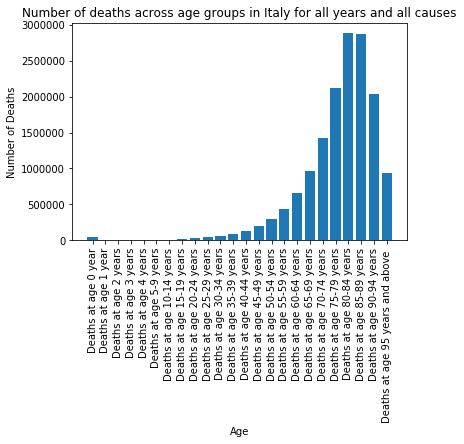

In [21]:
#Plot a bar chart of the number of deaths
plt.bar(age_groups,italy_ages_mortality.values)
plt.xticks(age_groups, rotation='vertical')
plt.xlabel('Age')
plt.ylabel('Number of Deaths')
plt.title('Number of deaths across age groups in Italy for all years and all causes')
plt.show()

The histogram gives a good visualization of the number of deaths increasing exponentially up to age 80-84.  After this point, the total number of deaths per age group decreases (since there are fewer people left at this age).  There is also a small but notable number of infant deaths at age 0 year.

### Question 3
I will now look in more detail at causes of death in Italy, specifically for *Neoplasms*.  ICD-10 codes C00 to D48 cover neoplasms.  In the mortality data set, these are sometimes coded with a condensed code (1026-1047), so I should search for both.

In [22]:
#Create a subset of the Italy mortality database for cancer
italy_neoplasms = italy_mort_df[(italy_mort_df['Cause'].between('C00','D48'))|\
                               (italy_mort_df['Cause'].between('1026','1047'))]

#Group data by 'Cause' for all years and sexes.  Sum remaining columns, show total deaths as 'Deaths1'
italy_neoplasms = italy_neoplasms.groupby('Cause').sum()[['Deaths1']]
italy_neoplasms.columns = ['Total Deaths']

#Calculate the total number of deaths due to neoplasms
total_neoplasm_deaths = italy_neoplasms['Total Deaths'].sum()

#Create a new column: proportion of deaths (%)
italy_neoplasms['Proportion'] = italy_neoplasms['Total Deaths']/total_neoplasm_deaths*100

#Sort the dataset
italy_neoplasms = italy_neoplasms.sort_values(by=['Total Deaths'], ascending=False)

#Create a dataset of the top 5
italy_neoplasms_top5 = italy_neoplasms.iloc[0:5]
italy_neoplasms_top5

,Total Deaths,Proportion
Cause,,
C349,426451,19.041893
C509,155895,6.961025
C189,143188,6.393632
C169,125679,5.611820
C259,120070,5.361366


In [23]:
# Create a dictionary of the causes
neoplasm_dict = {'C349': 'Malignant neoplasm: Bronchus or lung, unspecified',
                 'C509': 'Malignant neoplasm: Breast, unspecified ',
                 'C189': 'Malignant neoplasm: Colon, unspecified',
                 'C169': 'Malignant neoplasm of Stomach, unspecified',
                 'C259': 'Malignant neoplasm: Pancreas, unspecified  '}

In [15]:
#Create a data set for the remaining causes - group as 'Other'
other_neoplasms = italy_neoplasms.iloc[5:].reset_index()
other_neoplasms['Cause'] = 'Other'
other_neoplasms = other_neoplasms.groupby('Cause').sum()

In [29]:
#Add other to the top 5 causes
italy_neoplasms_top5 = italy_neoplasms_top5.append(other_neoplasms)
italy_neoplasms_top5.rename(index=neoplasm_dict, inplace=True)

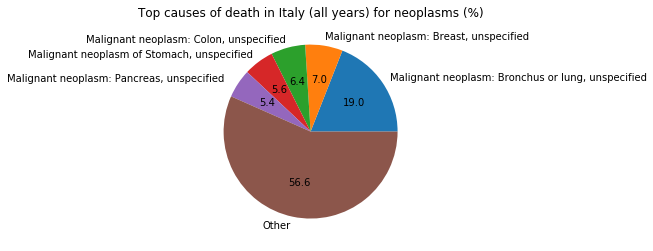

In [54]:
#Create a pie chart of the top causes of death for neoplasms
plt.pie(italy_neoplasms_top5['Proportion'], labels =italy_neoplasms_top5.index, autopct='%1.1f')
plt.title('Top causes of death in Italy (all years) for neoplasms (%)')
plt.show()

## Question 4
I will now switch to looking at Australia, and identify the top five age groups dying with a *Neoplasms* cause of death.

In [18]:
#Find country code for australia
aus = country_code('Australia')
aus

,Country,Name
211,5020,Australia


In [472]:
#Create a subset of the mortality dataset for 2010
all_mort_2010 = mort_df[mort_df['Year'] == 2010]

#Create criteria for neoplasms (coded with ICD-10 or condensed WHO code)
criteria1 = all_mort_2010['Cause'].between('1026','1047')
criteria2 = all_mort_2010['Cause'].between('C00','D48')

#Create a subset of mortality 2010 for neoplasms
neoplasms_2010 = all_mort_2010[criteria1 | criteria2]

#Create a subset for Australia
aus_neoplasms = neoplasms_2010[neoplasms_2010['Country']==5020]
aus_neoplasms.head()

,Country,Admin1,SubDiv,Year,List,Cause,Sex,Frmat,IM_Frmat,Deaths1,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
2259359,5020,NaN,NaN,2010,104,C001,1,0,1,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2259360,5020,NaN,NaN,2010,104,C001,2,0,1,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2259361,5020,NaN,NaN,2010,104,C009,1,0,1,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2259362,5020,NaN,NaN,2010,104,C009,2,0,1,5,...,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2259363,5020,NaN,NaN,2010,104,C01,1,0,1,20,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [473]:
#Create a series with the total deaths from neoplasm in Australia 2010 for each age group
aus_neoplasms_grouped = aus_neoplasms.iloc[:,10:34].sum()

#Rename the index column with descriptive labels
aus_neoplasms_grouped.index = age_groups

#Sort the groups to identify top 5 age groups in Australia dying with a Neoplasms cause of death
print("Top 5 age groups for death from Neoplasms in Australia 2010:")
aus_neoplasms_grouped.sort_values(ascending=False)[0:5]

Top 5 age groups for death from Neoplasms in Australia 2010:


Deaths at age 80-84 years    7165.0
Deaths at age 75-79 years    6281.0
Deaths at age 70-74 years    5709.0
Deaths at age 85-89 years    5512.0
Deaths at age 65-69 years    4765.0
dtype: float64

Death from *Neoplasms* was most common in 80-84 year olds in Australia in 2010.  The other top 5 age groups are all older people (75-79 year, 70-74 years, 85-89 years and 65-69 years).  This is similar to the distribution of deaths by all causes in Italy that I looked at in Question 2.

## Question 5
Finally, I will compare and contrast the frequency of deaths by *Neoplasms* in Italy and Australia in 2010.

In [474]:
#Create a dataframe to compare 
q5_countries = country_code('Italy','Australia')

#Merge with population from population 2010 data frame
q5_countries = q5_countries.merge(pop_2010, on='Country')

#Create dataframe with total neoplasms for each country
neoplasms_grouped = neoplasms_2010.groupby('Country').sum().reset_index()[['Country','Deaths1']]

#Add deaths from neoplasms to countries dataset
q5_countries = q5_countries.merge(neoplasms_grouped, on='Country')

#Calculate crude death rate
q5_countries['Death Rate (per 100,000 of population)'] = q5_countries['Deaths1']/q5_countries['Pop1']*100000
q5_countries.rename(columns={'Pop1':'Population', 'Deaths1':'Total Deaths'})

,Country,Name,Population,Total Deaths,"Death Rate (per 100,000 of population)"
0,4180,Italy,60483386.0,174405,288.351912
1,5020,Australia,22297515.0,43276,194.084408


Text(0.5, 0, 'Country')

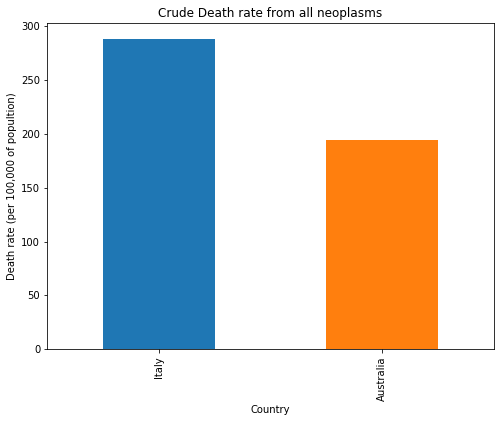

In [808]:
ax1 = q5_countries.plot.bar(x='Name', y='Death Rate (per 100,000 of population)',figsize=(8,6),legend=False)
ax1.set_title('Crude Death rate from all neoplasms')
ax1.set_ylabel('Death rate (per 100,000 of popultion)')
ax1.set_xlabel('Country')

<p>Italy had a higher total number deaths by Neoplasm than Australia in 2010 (174,405 compared to 43,276).</p>
<p>However, the population of Italy is nearly three times the population of Australia, so death rate is a more meaningful statistic.  Calculating death rate (expressed as deaths per 100,000 of the population) shows that Italy has a higher death rate than Australia (288 compared to 194).</p>
<p>We have observed in Question 4 that death by Neoplasm is more common in older people.  Therefor, Italy's higher death rate may be due to having an older population.  In order to fairly compare death rates between countries, it is common to standardize the population age structure.  I will do this now.

In [809]:
#Create a new data frame for Italy and Australia in order to calculate age-standarized death rates
q5_countries_2 = country_code('italy','australia')

#Generate dataframe for population and deaths for all age groups
pop_2010_2 = year_totals(2010,pop_df)
deaths_2010_2 = neoplasms_2010.groupby('Country').sum().reset_index()

#Select Country, Year and Age groups 2-25 
col_selection = ['Country','Year']
pop_selection = ['Pop'+str(x) for x in range(1,26)]
deaths_selection = ['Deaths'+str(x) for x in range(1,26)]

#merge to create dataset with column for population and death for each age group
q5_countries_2 = q5_countries_2.merge(pop_2010_2[col_selection + pop_selection], on='Country')
q5_countries_2 = q5_countries_2.merge(deaths_2010_2[['Country'] + deaths_selection], on='Country')

#Create columns for Age-specific Rates
for i in range(2,26):
    i=str(i)
    q5_countries_2['Rate'+i] = q5_countries_2['Deaths'+i]/q5_countries_2['Pop'+i]
q5_countries_2

,Country,Name,Year,Pop1,Pop2,Pop3,Pop4,Pop5,Pop6,Pop7,...,Rate16,Rate17,Rate18,Rate19,Rate20,Rate21,Rate22,Rate23,Rate24,Rate25
0,4180,Italy,4020,60483386.0,559179.0,571110.0,573359.0,571598.0,570307.0,2838221.0,...,0.001386,0.002298,0.003731,0.005746,0.008209,0.011765,0.016420,0.020414,0.022993,0.021794
1,5020,Australia,4020,22297515.0,289368.0,297513.0,294321.0,286030.0,282736.0,1365354.0,...,0.001196,0.002031,0.003251,0.005247,0.008040,0.011357,0.016287,0.020774,0.023344,0.025022


In [810]:
#Create standardised populations for age group based on the mean between italy and australia
age_standard = q5_countries_2.groupby('Year').mean().reset_index()[col_selection+pop_selection]
age_standard

,Country,Year,Pop1,Pop2,Pop3,Pop4,Pop5,Pop6,Pop7,Pop8,...,Pop16,Pop17,Pop18,Pop19,Pop20,Pop21,Pop22,Pop23,Pop24,Pop25
0,4600.0,4020,41390450.5,424273.5,434311.5,433840.0,428814.0,426521.5,2101787.5,2107819.0,...,2781540.5,2520617.5,2484349.0,2007945.5,1889398.0,1542492.5,1175970.5,712402.0,218889.0,82725.0


In [811]:
#Create Age Standardised Deaths based on age-group death rate and standardized population size
for i in range(2,26):
    i=str(i)
    q5_countries_2['Std_Deaths'+i] = q5_countries_2['Rate'+i] * age_standard.loc[0,'Pop'+i]
q5_countries_2

,Country,Name,Year,Pop1,Pop2,Pop3,Pop4,Pop5,Pop6,Pop7,...,Std_Deaths16,Std_Deaths17,Std_Deaths18,Std_Deaths19,Std_Deaths20,Std_Deaths21,Std_Deaths22,Std_Deaths23,Std_Deaths24,Std_Deaths25
0,4180,Italy,4020,60483386.0,559179.0,571110.0,573359.0,571598.0,570307.0,2838221.0,...,3853.906673,5792.082635,9269.596299,11537.703532,15510.487162,18146.769905,19309.702880,14542.628218,5032.943855,1802.909170
1,5020,Australia,4020,22297515.0,289368.0,297513.0,294321.0,286030.0,282736.0,1365354.0,...,3327.473553,5120.341615,8077.476106,10535.237412,15191.243996,17517.738323,19153.571835,14799.699330,5109.848476,2069.968122


In [812]:
#Create column of sum of total standardised deaths for all age groups (columns 77:101)
q5_countries_2['Total_Std_Deaths'] = q5_countries_2[q5_countries_2.columns[77:101]].sum(axis=1)
q5_countries_2[['Name','Deaths1','Total_Std_Deaths']]

,Name,Deaths1,Total_Std_Deaths
0,Italy,174405,109878.655399
1,Australia,43276,105554.303078


In [813]:
#Create column for Age-Standardized death Rate from cancer
q5_countries_2['Std_Rate'] = q5_countries_2['Total_Std_Deaths'] / age_standard.loc[0,'Pop1']*100000
q5_countries_2[['Name','Std_Rate']]

,Name,Std_Rate
0,Italy,265.468614
1,Australia,255.020909


Text(0.5, 0, 'Country')

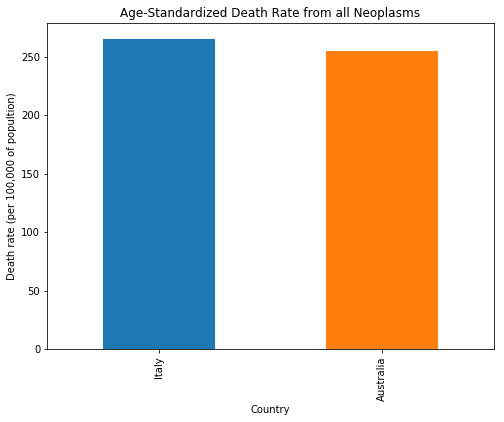

In [814]:
#plot the age-standardized bar chart
ax2 = q5_countries_2.plot.bar(x='Name', y='Std_Rate',figsize=(8,6),legend=False)
ax2.set_title('Age-Standardized Death Rate from all Neoplasms')
ax2.set_ylabel('Death rate (per 100,000 of popultion)')
ax2.set_xlabel('Country')

After standardizing the population age structure (taken as the mean between Australia and Italy), the age-standardized death rate is calculated.  This is the death rate if each country had the same death rate within each age group as is observed, but instead had a standard population structure.  This shows that although Italy still has a slightly higher death rate from Neoplasms, it is not as different as in the crude analysis (265 compared to 255 per 100,000 population).